# Layer 1
Predicting relevant and irrelevant topics

In [41]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from joblib import load, dump
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score # get a specific score of a model using CV
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # a list of english stop words
from sklearn.preprocessing import LabelEncoder

from sklearn.exceptions import ConvergenceWarning

In [42]:
df_train = pd.read_csv("../training.csv")

df_test = pd.read_csv("../test.csv")

## 1. encode labels to relevant: 0, irrelevent: 1

In [43]:
text_train = df_train.article_words
label_train = df_train.topic


y_train = np.where(df_train.topic == "IRRELEVANT", 0, 1)
y_train.sum()

4766

In [44]:
# Insert the encoded column into original dataframe
df_train["is_relevent"] = y_train
df_train.head()

,article_number,article_words,topic,is_relevent
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,1
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,1
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,1
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,1
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,0


In [45]:
vect = CountVectorizer(min_df=5)
X_train = vect.fit_transform(text_train)
X_train

<9500x9495 sparse matrix of type '<class 'numpy.int64'>'
	with 719744 stored elements in Compressed Sparse Row format>

In [46]:
%%time
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all

accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train, y_train, cv=5)
print(f"Mean accuracy (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")

Mean accuracy (std):  0.832 ( 0.004)
CPU times: user 132 ms, sys: 81.9 ms, total: 214 ms
Wall time: 3.46 s


In [47]:
%%time
param_grid = {'C': np.geomspace(0.001,10,num=5,endpoint=True)}

grid = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"best parameter: {grid.best_params_}")
print(f"best 5-fold CV score (accuracy): {grid.best_score_: .3f}")

best parameter: {'C': 0.01}
best 5-fold CV score (accuracy):  0.859
CPU times: user 74.1 ms, sys: 14.7 ms, total: 88.8 ms
Wall time: 4.94 s


In [48]:
%%time
text_test = df_test.article_words # training set containing text content
label_test = df_test.topic

# encode labels to relevant: 0, irrelevent: 1
y_test = np.where(df_test.topic == "IRRELEVANT", 0, 1)
y_test.sum()

X_test = vect.transform(text_test)
acc_test = grid.score(X_test, y_test)
print(f"Logistic regression accuracy on test set: {acc_test:.3f}")

Logistic regression accuracy on test set: 0.880
CPU times: user 35.4 ms, sys: 3.49 ms, total: 38.9 ms
Wall time: 38.9 ms


## 2. Hyperparameter Tuning

In [49]:
# standard pipeline interface
estimators = [
              ("tfidf", TfidfVectorizer(norm=None)),
              ("LR", LogisticRegression(n_jobs=-1))
             ]

pipe = Pipeline(estimators)

# Notice here parameters need to be specified to which step in the pipeline they belong to
param_grid = {
              "tfidf__min_df": np.arange(6),
              "LR__class_weight": ["balanced", None],
              "LR__multi_class": ["ovr", "multinomial"],
              "LR__C": [0.0001, 0.01, 0.1, 1, 10],
             }
pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [50]:
%%time
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)

# pass in original text samples
grid.fit(text_train, y_train)

# Extract the optimal steps we have obtained sofar
clf_logi = grid.best_estimator_

# Report accuracy scores on training and test set
acc_train = grid.best_score_
print(f"Best parameter: {grid.best_params_}")
print(f"Accuracy on training set: {acc_train:.3f}")

/import/ravel/1/z5244619/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameter: {'LR__C': 0.0001, 'LR__class_weight': None, 'LR__multi_class': 'multinomial', 'tfidf__min_df': 4}
Accuracy on training set: 0.865
CPU times: user 12.6 s, sys: 4.37 s, total: 17 s
Wall time: 14min 57s


In [55]:
import os
from joblib import dump, load

file_name = "Models/best_logi_layer1.joblib"
if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
    with open(file_name, "wb") as file:
        dump(clf_logi, file, compress=True)
else:
    print("Warn: this model already exits...")

## Test on the Best LogisticRegressor
See the cell below for location and usage of the model

In [52]:
y_pred = clf_logi.predict(text_test)
acc_test = clf_logi.score(text_test, y_test)
print(f"Accuracy on test set: {acc_test:.3f}")

Accuracy on test set: 0.878


In [53]:
from sklearn.metrics import classification_report, confusion_matrix

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       266
           1       0.87      0.87      0.87       234

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



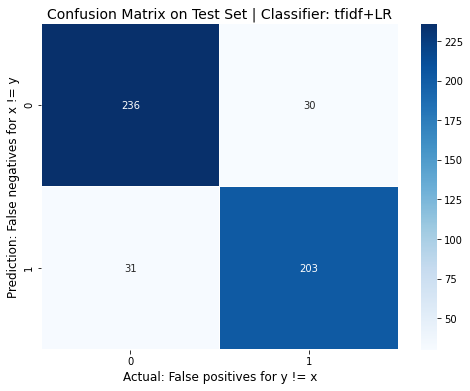

In [54]:
fig1 = plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,
#             square=True,
            annot=True, # show numbers in each cell
            fmt='d', # set number format to integer in each cell
#             yticklabels=encoder.classes_,
#             xticklabels=clf_logi.classes_,
            cmap="Blues",
#             linecolor="k",
            linewidths=.1,
           )
plt.title(
          f"Confusion Matrix on Test Set | " 
          f"Classifier: {'+'.join([step for step in clf_logi.named_steps.keys()])}", 
          fontsize=14)
plt.xlabel("Actual: False positives for y != x", fontsize=12)
plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
plt.show()